In [1]:
import numpy as np
import itertools
import sys
sys.path.append("..")

In [2]:
from utility_functions import (calculate_model_performance,
                               plot_ROC)

In [3]:
def get_shapes(any_):
    for array in any_:
        try:
            print(array.shape)
        except:
            print("NONE")
    print("\n")

In [4]:
# ============= ACTIVATION FUNCTIONS ===============#

def sigmoid(Z, prime=False):
    # np.
    if prime:
        return sigmoid(Z) * (1 - sigmoid(Z))
    return 1 / (1 + np.exp(-Z))


def linear(Z, prime=False):
    if prime:
        return np.ones_like(Z)
    return Z


def relu(Z, alpha=0, prime=False):
    if prime:
        Z_relu = np.ones_like(Z, dtype=np.float64)
        Z_relu[Z < 0] = alpha
        return Z_relu
    return np.where(Z < 0, alpha * Z, Z)


def tanh(Z, prime=False):
    # np.tanh() could be used directly to speed this up
    if prime:
        return 1 - np.power(tanh(Z), 2)
    return (2 / (1 + np.exp(-2 * Z))) - 1


def elu(Z, prime=False):
    # https://mlfromscratch.com/activation-functions-explained/#/
    alpha = 0.2
    if prime:
        return np.where(Z < 0, alpha * (np.exp(Z)), 1)
    return np.where(Z < 0, alpha * (np.exp(Z) - 1), Z)


def softmax(Z, prime=False):
    if prime:
        return 1
    return np.exp(Z) / np.sum(np.exp(Z),axis=0)

In [5]:
# ============== LOSS FUNCTIONS ===============#

# https://deepnotes.io/softmax-crossentropy
EPSILON = 1e-12

def calculate_error(Y, Y_hat, loss_function="MSE"):
    m = Y.shape[1]
    if loss_function == "MSE":
        return np.sum(0.5 * np.square(Y - Y_hat)) / m
    elif loss_function == "categorical_crossentropy":
        return -np.sum(Y * np.log(Y_hat + EPSILON)) / m

In [6]:
# References
# https://mc.ai/multilayered-neural-network-from-scratch-using-python/
# https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/
# https://www.coursera.org/learn/machine-learning/home/week/5
# https://www.coursera.org/specializations/deep-learning
# https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/src/network.py
# https://github.com/JWarmenhoven/Coursera-Machine-Learning

class NeuralNetwork:
    

    def __init__(
        self,
        input_layer: tuple,
        hidden_layer: list, # list of tuples
        output_layer: int,
        batch_size: int,
        loss_function: str,
        alpha: float,
        epoch: int,
        random_state: int
    ):
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        self.mini_batch_size = batch_size
        self.loss_function = loss_function
        self.alpha = alpha
        self.epoch = epoch
        self.seed = random_state
        
        self.m = X.shape[1] # where (no_of_features, no_of_training_examples)
        self.layers = len(self.weight_set_dimensions) + 1
    
    def get_A(self, X):
        A, _ = self.forwardpass(X)
        return A
    
    def get_Z(self, X):
        _, Z = self.forwardpass(X)
        return Z


    def calculate_delta_final(self, Y, Y_hat, Z):
        final_act_func = self.activation_functions[-1]
        arg_to_pass_to_eval = "(Z[-1], prime=True)"
        
        if self.loss_function == "MSE":
            dLA = Y_hat - Y
        elif self.loss_function == "categorical_crossentropy":
            dLA = Y_hat - Y
            
        dLZ = dLA * eval(final_act_func + arg_to_pass_to_eval)
        return dLZ


    def get_dimensions_and_activations(self):
        self.dimensions = []
        self.activation_functions = []
        
        self.dimensions.append(self.input_layer[0])
        self.activation_functions.append(self.input_layer[1])

        for dim, act_func in self.hidden_layer:
            self.dimensions.append(dim)
            self.activation_functions.append(act_func)

        self.dimensions.append(self.output_layer)

        
    @property
    def weight_set_dimensions(self):
        self.get_dimensions_and_activations()
        a, b = itertools.tee(self.dimensions[::-1])
        next(b, None)
        weight_set_dimensions = list(zip(a, b))[::-1]
        return weight_set_dimensions


    def initialise_weights(self):

        self.W = np.empty_like(range(self.layers), dtype=object)
        self.B = np.empty_like(range(self.layers), dtype=object)
        self.W[0] = None
        self.B[0] = None
        for layer, (y, x) in zip(range(1, self.layers), self.weight_set_dimensions):
            np.random.seed(self.seed)
            self.W[layer] = np.random.rand(y, x)
            self.B[layer] = np.random.rand(y, 1)


    def forwardpass(self, X):
        Z = np.empty_like(range(self.layers), dtype=object)
        A = np.empty_like(range(self.layers), dtype=object)
        A[0] = X
        Z[0] = None
        for layer in range(1, self.layers):
            # activation_function starts from 0 whereas layer starts from 1
            active_function = self.activation_functions[layer - 1]
            arg_to_pass_to_eval = "(Z[layer])"
            
            Z[layer] = self.W[layer] @ A[layer - 1] + self.B[layer]
            A[layer] = eval(active_function + arg_to_pass_to_eval)
        return A, Z
            


    def backpropagation(self, Y, A, Z):
        delta_final = self.calculate_delta_final(Y, A[-1], Z)
        self.delta = np.empty_like(range(self.layers), dtype=object)
        self.delta[0] = None
        self.delta[-1] = delta_final

        self.gradient_W = np.empty_like(range(self.layers), dtype=object)
        self.gradient_B = np.empty_like(range(self.layers), dtype=object)
        self.gradient_W[0] = None
        self.gradient_B[0] = None
        
        # We substract 1 here as delta_final is calculated seperately above
        for layer in reversed(range(1, self.layers - 1)):
            active_function = self.activation_functions[layer - 1]
            arg_to_pass_to_eval = "(Z[layer], prime=True)"

            self.delta[layer] = (
                self.W[layer + 1].T @ self.delta[layer + 1] *
                eval(active_function + arg_to_pass_to_eval)
            ) 
            # E.g. eval part might correspond to -> sigmoid(self.Z[layer], prime=True)

        # calculate the gradient
        for layer in range(1, self.layers):
            self.gradient_W[layer] = (self.delta[layer] @ A[layer - 1].T) / self.m
            self.gradient_B[layer] = np.sum(self.delta[layer], axis=1, keepdims=True) / self.m

        #update the weights
        for layer in range(1, self.layers):
            self.W[layer] -= self.alpha * self.gradient_W[layer]
            self.B[layer] -= self.alpha * self.gradient_B[layer]
            
            
    def fit(self, X, Y):
        self.initialise_weights()
        
        # By default the method is SGD(Stochastic Gradient Descent) if one wishes to use
        # the whole batch, simply pass the number of traning examples available as the
        # batch size when instantiating the class
        self.no_of_iterations = 0
        shuffled = np.arange(self.m)
        print("Initialising weights...")
        print("Starting the training...")
        print("Initial cost: %.10f\n" %calculate_error(Y,
                                                       self.get_A(X)[-1],
                                                       loss_function=self.loss_function))
        for epoch_no in range(1, self.epoch + 1):
            np.random.shuffle(shuffled)
            X_shuffled = X[:, shuffled]
            Y_shuffled = Y[:, shuffled]
            for i in range(0, self.m, self.mini_batch_size):
                self.no_of_iterations += 1
                X_mini_batch = X_shuffled[:, i: i + self.mini_batch_size]
                Y_mini_batch = Y_shuffled[:, i: i + self.mini_batch_size]
                A, Z = self.forwardpass(X_mini_batch)
                self.backpropagation(Y_mini_batch, A, Z)
                if self.no_of_iterations % 5000 == 0:
                    model_performance_metrics = calculate_model_performance(
                        np.argmax(Y, axis=0),
                        self.predict(X)
                    )
                    print("F1 score: %.10f - epoch %s    iteration %s - loss %.20f" %(
                            model_performance_metrics["F1"],
                            epoch_no,
                            self.no_of_iterations,
                            calculate_error(Y,
                                            self.get_A(X)[-1],
                                            loss_function=self.loss_function)
                        )
                    )


    def predict(
        self,
        X: np.ndarray,
        return_prob_matrix=False
    ):
        """Predict the output given the training data.

            Returns the predicted values in two forms:

            1.either by picking up the highest value along the columns for every row,
                i.e. "np.argmax(self.A[-1].T, axis=1)"
            2.or by returning a matrix that is in the shape of Y.T where each column
                represents the probability of the instance belonging to that class.
                Please note that every column in Y.T represents a class. To be able to
                return the probability matrix, the final activation function must be
                softmax!
                i.e. "array([0.9650488423, 0.0354737543, 0.0005225966])"

        Args:
            X (numpy.ndarray): Training set in the shape of
                (no_of_features, no_of_training examples).
            return_prob_matrix (bool, optional): Returns the probability matrix if True.
                Defaults to False.
        
        Returns:
            numpy.ndarray:
            
            if return_prob_matrix is False, the output is in the shape of
                (no_of_training_examples, 1)
            if return_prob_matrix is True, the output is in the shape of
                (no_of_training_examples, no_of_features)
        """
        A, Z = self.forwardpass(X)
        if return_prob_matrix and self.activation_functions[-1] == "softmax":
            np.set_printoptions(precision=10, suppress=True)
            return A[-1].T
        return np.argmax(A[-1].T, axis=1)

# Testing with benchmark datasets

## 1.Iris Dataset

In [183]:
from sklearn.datasets import load_iris
data = load_iris()
X = data.data[:,[0,2]].T
y = data.target
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y = lb.fit_transform(y)
Y = Y.T

In [184]:
print(X.shape)
print(Y.shape)

(2, 150)
(3, 150)


In [185]:
model = NeuralNetwork(
    input_layer=(2, "relu"),
    hidden_layer=[(4, "sigmoid"),
                  (4, "softmax")],
    output_layer=3,
    batch_size=64,
    loss_function="categorical_crossentropy",
    alpha=0.5,
    epoch=25000,
    random_state=42
)

model.fit(X, Y)

Initialising weights...
Starting the training...
Initial cost: 1.4182103754

F1 score: 82.3529411740 - epoch 1667    iteration 5000 - loss 0.28540305056916137616
F1 score: 92.6315789449 - epoch 3334    iteration 10000 - loss 0.13024776103867022337
F1 score: 90.1098901074 - epoch 5000    iteration 15000 - loss 0.12927495223717880291
F1 score: 95.1456310656 - epoch 6667    iteration 20000 - loss 0.10694234779743559682
F1 score: 87.6404494357 - epoch 8334    iteration 25000 - loss 0.15792585724228397348
F1 score: 95.1456310656 - epoch 10000    iteration 30000 - loss 0.09274828063614207196
F1 score: 94.7368421028 - epoch 11667    iteration 35000 - loss 0.09670898057481727705
F1 score: 94.1176470565 - epoch 13334    iteration 40000 - loss 0.08077678030071669402
F1 score: 94.8453608223 - epoch 15000    iteration 45000 - loss 0.08190194193945267431
F1 score: 94.1176470565 - epoch 16667    iteration 50000 - loss 0.07849149228141910628
F1 score: 94.9494949471 - epoch 18334    iteration 55000 - 

In [186]:
model.predict(X) == np.argmax(Y, axis=0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,

In [187]:
model_performance_metrics = calculate_model_performance(
    np.argmax(Y, axis=0),
    model.predict(X)
)

In [188]:
model_performance_metrics

{'F1': 94.84536082228719,
 'accuracy': 96.66666666602222,
 'false_positive_rate': 0.99999999999,
 'precision': 97.87234042344953,
 'prevalence': 33.33333333311111,
 'sensitivity/recall': 91.99999999816,
 'specificity': 98.99999999900999}

C:\Anaconda3\lib\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Anaconda3\lib\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


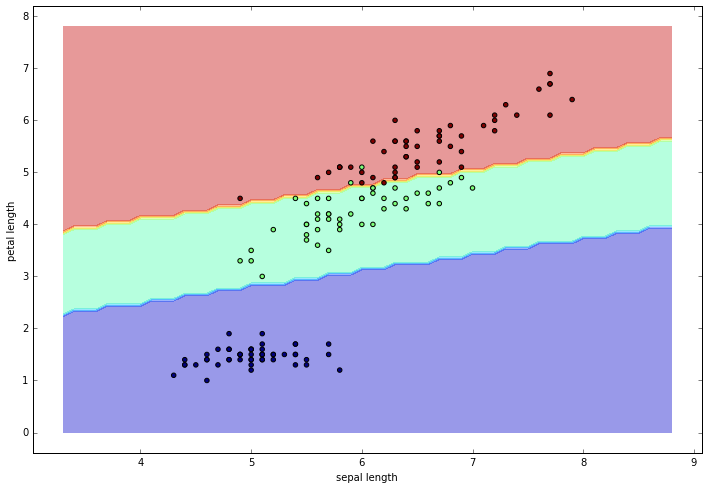

In [189]:
%matplotlib inline
import matplotlib.pyplot as plt
dt = data.data[:,[0,2]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.xlabel('sepal length')
plt.ylabel('petal length')

## 2.Make Moons dataset

In [177]:
from sklearn.datasets import make_moons
from sklearn import preprocessing

x,y =make_moons(n_samples=1500, noise=.05)
X = x.T
lb = preprocessing.LabelBinarizer()
Y = lb.fit_transform(y)
y_next = np.where(y==0,1,0)
Y = Y.T
Y = list(Y)
Y.append(y_next)
Y = np.array(Y)

print(X.shape)
print(Y.shape)

(2, 1500)
(2, 1500)


In [178]:
model = NeuralNetwork(
    input_layer=(2, "sigmoid"),
    hidden_layer=[(8, "tanh"),
                  (6, "relu"),
                  (4, "softmax")],
    output_layer=2,
    batch_size=64,
    loss_function="categorical_crossentropy",
    alpha=0.5,
    epoch=5000,
    random_state=42
)


model.fit(X, Y)

Initialising weights...
Starting the training...
Initial cost: 2.3780517967

F1 score: 66.6666666662 - epoch 209    iteration 5000 - loss 0.69351689477063460654
F1 score: 66.6666666662 - epoch 417    iteration 10000 - loss 0.69413687263893186774
F1 score: 0.0000000000 - epoch 625    iteration 15000 - loss 0.69315898495189287587
F1 score: 66.6666666662 - epoch 834    iteration 20000 - loss 0.69328883543686681268
F1 score: 0.0000000000 - epoch 1042    iteration 25000 - loss 0.69326473502744978550
F1 score: 0.0000000000 - epoch 1250    iteration 30000 - loss 0.69311552923515284963
F1 score: 66.6666666662 - epoch 1459    iteration 35000 - loss 0.69334071925909013245
F1 score: 48.8160291434 - epoch 1667    iteration 40000 - loss 0.69304168299615531712
F1 score: 0.0000000000 - epoch 1875    iteration 45000 - loss 0.69306329741980077230
F1 score: 66.6666666662 - epoch 2084    iteration 50000 - loss 0.69301204487935186282
F1 score: 61.7594254932 - epoch 2292    iteration 55000 - loss 0.6764869

C:\Anaconda3\lib\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Anaconda3\lib\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


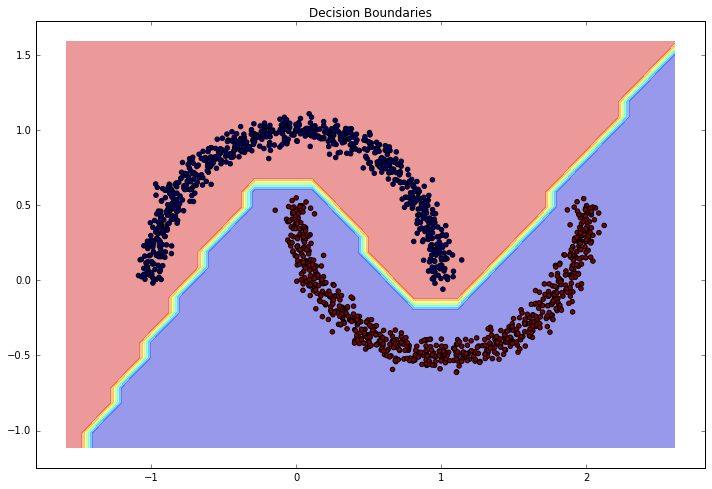

In [179]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = x
x_min, x_max = dt[:, 0].min() - 0.5, dt[:, 0].max() + 0.5
y_min, y_max = dt[:, 1].min() - 0.5, dt[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.title('Decision Boundaries')

## 3.Andrew NG Assignment 2 Dataset

In [165]:
ex2data2 = np.loadtxt(r"C:\Users\mardic\Desktop\HackerRank\Andrew-NG-Coursera-master\ex2\data\ex2data2.txt", delimiter=",")

X = ex2data2[:, :-1]
y = ex2data2[:, -1]

X = X.T
Y = y.T

In [166]:
import pandas as pd

Y = pd.get_dummies(Y).values.T

In [167]:
print(X.shape)
print(Y.shape)

(2, 118)
(2, 118)


In [168]:
model = NeuralNetwork(
    input_layer=(2, "sigmoid"),
    hidden_layer=[(8, "tanh"),
                  (6, "relu"),
                  (4, "sigmoid")],
    output_layer=2,
    batch_size=64,
    loss_function="categorical_crossentropy",
    alpha=0.8,
    epoch=25000,
    random_state=42
)

model.fit(X, Y)

Initialising weights...
Starting the training...
Initial cost: 0.0068215365

F1 score: 0.0000000000 - epoch 2500    iteration 5000 - loss 0.69293762148423299063
F1 score: 0.0000000000 - epoch 5000    iteration 10000 - loss 0.69288830299401193979
F1 score: 60.2941176457 - epoch 7500    iteration 15000 - loss 0.67469849034282591838
F1 score: 77.7777777760 - epoch 10000    iteration 20000 - loss 0.50056434177482256320
F1 score: 84.6153846136 - epoch 12500    iteration 25000 - loss 0.40629822332610177060
F1 score: 83.9285714266 - epoch 15000    iteration 30000 - loss 0.33077722059935565913
F1 score: 89.0756302501 - epoch 17500    iteration 35000 - loss 0.28151136843287699607
F1 score: 88.1355932183 - epoch 20000    iteration 40000 - loss 0.28190670579298499066
F1 score: 87.6033057832 - epoch 22500    iteration 45000 - loss 0.25219826471242096089
F1 score: 90.7563025190 - epoch 25000    iteration 50000 - loss 0.23637554734912211152


In [169]:
model_performance_metrics = calculate_model_performance(
    np.argmax(Y, axis=0),
    model.predict(X)
)

model_performance_metrics

{'F1': 90.75630251898342,
 'accuracy': 90.67796610092645,
 'false_positive_rate': 11.666666666472223,
 'precision': 88.52459016248321,
 'prevalence': 49.15254237246481,
 'sensitivity/recall': 93.10344827425683,
 'specificity': 88.33333333186111}

C:\Anaconda3\lib\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Anaconda3\lib\site-packages\numpy\ma\core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


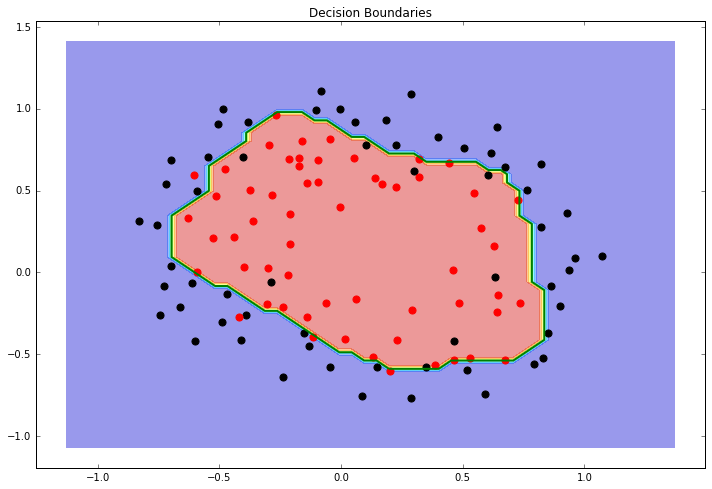

In [170]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
X = ex2data2

x1_min, x1_max = X[:, 0].min() - 0.3, X[:, 0].max() + 0.3,
x2_min, x2_max = X[:, 1].min() - 0.3, X[:, 1].max() + 0.3,
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()].T) 

negatives = ex2data2[ex2data2[:, -1] == 0]
positives = ex2data2[ex2data2[:, -1] == 1]

# Put the result into a color plot
Z = Z.reshape(xx1.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx1, xx2, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(negatives[:, 0], negatives[:, 1],s=50, color='k')
plt.scatter(positives[:, 0], positives[:, 1],s=50, color='r')
plt.title('Decision Boundaries')

plt.contour(xx1, xx2, Z, [0.5], linewidths=2, colors="g")

In [ ]:
get_shapes(model.gradient_W)

In [ ]:
class NeuralNetwork:
    

    def __init__(
        self,
        input_layer: tuple,
        hidden_layer: list, # list of tuples
        output_layer: int,
        alpha: float,
        no_of_iterations: int,
    ):
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        self.alpha = alpha
        self.no_of_iterations = no_of_iterations
        
        self.m = X.shape[1] # where (no_of_features, no_of_training_examples)
        self.layers = len(self.weight_set_dimensions)


    def calculate_delta_final(self, Y):
        final_act_func = self.activation_functions[-1]
        arg_to_pass_to_eval = "(self.Z[-1], prime=True)"
        
        return (self.A[-1] - Y) * eval(final_act_func + arg_to_pass_to_eval)


    def get_dimensions_and_activations(self):
        self.dimensions = []
        self.activation_functions = []
        
        self.dimensions.append(self.input_layer[0])
        self.activation_functions.append(self.input_layer[1])

        for dim, act_func in self.hidden_layer:
            self.dimensions.append(dim)
            self.activation_functions.append(act_func)

        self.dimensions.append(self.output_layer)

        
    @property
    def weight_set_dimensions(self):
        self.get_dimensions_and_activations()
        a, b = itertools.tee(self.dimensions[::-1])
        next(b, None)
        weight_set_dimensions = list(zip(a, b))[::-1]
        return weight_set_dimensions


    def initialise_weights(self):

        self.W = np.empty_like(range(self.layers + 1), dtype=object)
        self.B = np.empty_like(range(self.layers + 1), dtype=object)
        self.W[0] = None
        self.B[0] = None
        # self.parameters = {}
        for layer, (y, x) in zip(range(self.layers), self.weight_set_dimensions):
            np.random.seed(42)
            self.W[layer + 1] = np.random.rand(y, x)
            self.B[layer + 1] = np.random.rand(y, 1)
#             self.parameters["W" + str(layer)] = np.random.rand(row, column)
#             self.parameters["B" + str(layer)] = np.random.rand(row, 1)


    def forwardpass(self, X):
#         self._params = {}
#         self._params["A0"] = X
        self.Z = np.empty_like(range(self.layers + 1), dtype=object)
        self.A = np.empty_like(range(self.layers + 1), dtype=object)
        self.A[0] = X
        self.Z[0] = None
        for layer in range(self.layers):
            # activation_function starts from 0 whereas layer starts from 1
            active_function = self.activation_functions[layer]
            arg_to_pass_to_eval = "(self.Z[layer + 1])"

            self.Z[layer + 1] = self.W[layer + 1] @ self.A[layer] + self.B[layer + 1]
            self.A[layer + 1] = eval(active_function + arg_to_pass_to_eval)

#             arg_to_pass_to_eval = "(self._params['Z' + str(layer)])"
#             self._params["Z" + str(layer)] = (self.parameters["W" + str(layer)] @
#                                               self._params["A" + str(layer - 1)] +
#                                               self.parameters["B" + str(layer)])
#             self._params["A" + str(layer)] = eval(active_function + arg_to_pass_to_eval)

    def backpropagation(self, Y, A, Z):
        delta_final = self.calculate_delta_final(Y, A, Z)
        self.delta = np.empty_like(range(self.layers + 1), dtype=object)
        self.delta[0] = None
        self.delta[-1] = delta_final

        self.gradient_W = np.empty_like(range(self.layers + 1), dtype=object)
        self.gradient_B = np.empty_like(range(self.layers + 1), dtype=object)
        self.gradient_W[0] = None
        self.gradient_B[0] = None

        # here Z[index+1] is passed instead of Z[index] this is because Z[0] is none.
        # So Z[index+1] is effectively Z[index].

        for layer in reversed(range(1, self.layers)):
            active_function = self.activation_functions[layer]
            arg_to_pass_to_eval = "(self.Z[layer], prime=True)"

            self.delta[layer] = (
                self.W[layer + 1].T @ self.delta[layer + 1] *
                eval(active_function + arg_to_pass_to_eval)
            )

        # calculate the gradient
        for layer in range(self.layers):
            self.gradient_W[layer + 1] = (self.delta[layer + 1] @ self.A[layer].T) / self.m
            self.gradient_B[layer + 1] = np.sum(self.delta[layer + 1], axis=1, keepdims=True) / self.m

        #update the weights
        for layer in range(self.layers):
            self.W[layer+1] -= self.alpha * self.gradient_W[layer+1]
            self.B[layer+1] -= self.alpha * self.gradient_B[layer+1]
            
            
    def fit(self, X, Y):
        self.initialise_weights()
        
        for iteration in range(self.no_of_iterations + 1):
            self.forwardpass(X)
            self.backpropagation(Y)
            if iteration % 100 == 0 or iteration == self.no_of_iterations:
                print("iteration %s - loss %.20f" %(iteration, calculate_error(Y, self.A[-1])))


    def predict(self, X):
        self.forwardpass(X)

        return np.argmax(self.A[-1].T, axis=1)

In [ ]:
list(range(1,35, 16))

In [ ]:
import numpy as np

In [ ]:
X.shape

In [ ]:
y = y.reshape(1, 150)

In [ ]:
for epoch_no in range(1, 500):
    np.random.shuffle(idx)
    X = X[:,idx]
    y = y[:,idx]
    for i in range(0,150, 16):
        X_batch = X[:,i:i + 16]
        print(i, X_batch.shape)
        y_batch = y[:,i:i + 16]

In [ ]:
idx = np.arange(0,X.shape[1])

In [ ]:
idx

In [ ]:
np.random.shuffle(idx)

In [ ]:
X = X[:,idx]

In [ ]:
X